In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re, random, pickle, glob, os, difflib
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="" 

In [2]:
train_root = 'train/'
test_root = 'test/'
model_root = 'models/'
plot_root = 'plots/'
train_set = ['x10_reads.fa']
test_sets = ['test_easy_1.fa', 'test_easy_2.fa', 'test_intermidate_1.fa', 'test_intermidate_2.fa', 'test_difficult_1.fa', 
             'test_difficult_2.fa', 'test_very_difficult_1.fa', 'test_very_difficult_2.fa']

In [3]:
df = read_fasta(train_root + train_set[0])
train_reads_original = np.array(seqs2onehot(np.array(df.seqs)))
train_reads = np.delete(train_reads_original,3,axis=2)
train_reads = np.expand_dims(train_reads, -1)
train_reads.shape

(169538, 150, 4, 1)

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 150 * 4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -0.5*tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [6]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [7]:
latent_dim = 32
width = 500
input_size = (150,4,1)
filter_size = (5, 4) 
epochs = 75
batch_size = 2048

In [8]:
ckpt_num = 'vanilla_vae'
ckpt_dir = os.path.join(model_root, ckpt_num, '')
if (os.path.isdir(ckpt_dir) == False):
    os.mkdir(os.path.join(ckpt_dir, ''))

In [ ]:
with strategy.scope():
    for f_size in [10]:
        for latent_dim in [32]:
            filter_size = (f_size, 4)
            model_path = os.path.join(model_root, ckpt_num, str(f_size)+'_'+str(latent_dim)+'.h5')
            hist_path = os.path.join(model_root, ckpt_num, str(f_size)+'_'+str(latent_dim))
            encoder_inputs = keras.Input(shape=input_size)
            c1 = layers.Conv2D(256, filter_size, strides=(2, 1), activation="relu", padding="same")(encoder_inputs)
            x = layers.Flatten()(c1)
            x = layers.Dense(256, activation="relu")(x)
            z_mean = layers.Dense(latent_dim, name="z_mean")(x)
            z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
            z = Sampling()([z_mean, z_log_var])
            encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
            print(encoder.summary())
            
            latent_inputs = keras.Input(shape=(latent_dim,))
            x = layers.Dense(75 * 4 * 256, activation="relu")(latent_inputs)
            x = layers.Reshape((75, 4, 256))(x)
#             x = layers.Conv2DTranspose(256, filter_size, strides=(2, 1), activation="sigmoid", padding="same")(x)
#             x = layers.Cropping2D(cropping=((0, 1), (0, 0)))(x)
            x = layers.Conv2DTranspose(256, filter_size, strides=(2, 1), activation="relu", padding="same")(x)
            decoder_outputs = layers.Conv2D(1, filter_size, activation="sigmoid", padding="same")(x)
            decoder = keras.Model([latent_inputs], decoder_outputs, name="decoder")
            print(decoder.summary())
            
            vae = VAE(encoder, decoder)
            vae.compile(optimizer=keras.optimizers.Adam(0.001))
            history = vae.fit(train_reads, epochs=epochs, batch_size=batch_size, verbose =1)
            with open(hist_path, 'wb') as f:
                pickle.dump(history.history, f)
            encoder.save(model_path)
            
            fig, ax1 = plt.subplots()
            ax1.plot(history.history['reconstruction_loss'], color='green')
            ax1.plot(history.history['loss'], color='red')


            ax2 = ax1.twinx()
            ax2.plot(history.history['kl_loss'])
            plot_path = os.path.join(plot_root, str(f_size)+'_'+str(latent_dim)+'_loss''.png')
            plt.savefig(plot_path)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 4, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 75, 4, 256)   10496       input_5[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 76800)        0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          19661056    flatten_2[0][0]                  
____________________________________________________________________________________________

83/83 [==============================] - 20s 235ms/step - loss: 228.5911 - reconstruction_loss: 224.2059 - kl_loss: 4.3852
Epoch 39/75
83/83 [==============================] - 20s 236ms/step - loss: 232.2853 - reconstruction_loss: 227.8268 - kl_loss: 4.4585
Epoch 40/75
83/83 [==============================] - 20s 235ms/step - loss: 221.6817 - reconstruction_loss: 217.1299 - kl_loss: 4.5518
Epoch 41/75
29/83 [=========>....................] - ETA: 12s - loss: 218.5779 - reconstruction_loss: 213.8113 - kl_loss: 4.7666

In [14]:
easy_1 = assign_labels(read_fasta(test_root + test_sets[0]), True)
test_reads_1 = np.array(seqs2onehot(np.array(easy_1.seqs)))
test_reads_1 = np.delete(test_reads_1, 3, axis=2)
test_reads_1 = np.expand_dims(test_reads_1, -1)

(105492, 2)


In [15]:
r1 = vae.predict(test_reads_1, verbose=1)

In [19]:
r2 = encoder.predict(test_reads_1, verbose=1)

3297/3297 [==============================] - 162s 49ms/step


In [20]:
r2.shape

AttributeError: 'list' object has no attribute 'shape'

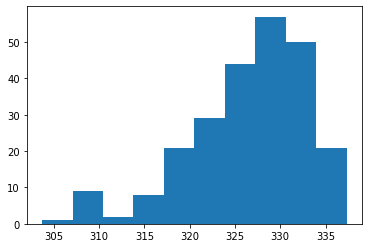

In [16]:
vclass = 1
l = keras.losses.binary_crossentropy(test_reads_1[np.array(easy_1.viral==vclass)], r1[np.array(easy_1.viral==vclass)])
x = tf.reduce_mean(l, [1,2])*600
plt.hist(np.array(x)); plt.show()

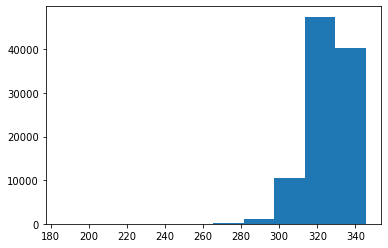

In [17]:
vclass = 2
l = keras.losses.binary_crossentropy(test_reads_1[np.array(easy_1.viral==vclass)], r1[np.array(easy_1.viral==vclass)])
x = tf.reduce_mean(l, [1,2])*600
plt.hist(np.array(x)); plt.show()

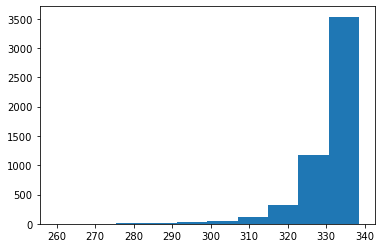

In [18]:
vclass = 0
l = keras.losses.binary_crossentropy(test_reads_1[np.array(easy_1.viral==vclass)], r1[np.array(easy_1.viral==vclass)])
x = tf.reduce_mean(l, [1,2])*600
plt.hist(np.array(x)); plt.show()